In [2]:
!pip install -q lightfm


[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [4]:
!pip install tensorflow-decision-forests



^C


In [8]:
from scipy import sparse
from typing import List
import datetime
import os

import lightfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from lightfm import LightFM
from lightfm.datasets import fetch_movielens

import tensorflow.keras as keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
    Dropout,
    BatchNormalization,
    ReLU
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

import pandas as pd

# Preprocess the Data

In [12]:
# datasets
tours_df = pd.read_csv('clean_vietnam_tours.csv')
inter_df = pd.read_csv('new_ratings.csv')

merged_df = pd.merge(inter_df, tours_df, on='tour_id')
merged_df

,user_id,tour_id,rating,timestamp,tour_name,description,duration,price,average_rating
0,115,19,4,11/25/2024 10:00,Explore Vietnam Holiday Trip with Halong Bay C...,Hanoi(1N) → Halong Bay(1N) → Hue(1N) → Hoi ...,8 Nights / 9 Days,21950000,3.3
1,14,99,1,11/23/2024 14:30,7 Days Honeymoon in Vietnam: Couple Special Pa...,Hanoi(2N) → Halong(1N) → Hanoi(1N) → Nha Tr...,6 Nights / 7 Days,21575000,4.1
2,28,85,5,11/20/2024 9:45,Romantic Royal Vietnam and Cambodia Tour: Comp...,Ho Chi Minh City(3N) → Siem Reap(2N),5 Nights / 6 Days,18950000,2.4
3,54,85,2,11/21/2024 18:20,Romantic Royal Vietnam and Cambodia Tour: Comp...,Ho Chi Minh City(3N) → Siem Reap(2N),5 Nights / 6 Days,18950000,2.4
4,70,33,1,11/22/2024 16:10,Treasures of Vietnam Family Package: Ba Na Hil...,Hanoi(2N) → Halong Bay(1N) → Da Nang(2N) → ...,7 Nights / 8 Days,21050000,3.4
...,...,...,...,...,...,...,...,...,...
6289,64,60,3,NaN,Vietnam Discovery: Unveil the Magic of 3 citie...,Hanoi(2N) → Da Nang(2N) → Ho Chi Minh City(2N),6 Nights / 7 Days,11725000,4.1
6290,12,66,4,NaN,Mesmerising Vietnam Honeymoon Tour including H...,Ho Chi Minh City(2N) → Hanoi(1N) → Halong Ba...,4 Nights / 5 Days,11125000,2.1
6291,100,30,4,NaN,Mesmerising Vietnam and Cambodia Honeymoon Tou...,Ho Chi Mihn City(3N) → Hanoi(3N) → Halong Bay ...,10 Nights / 11 Days,38825000,2.0
6292,3,82,3,NaN,Mui Ne Sand Dunes Package,Ho Chi Mihn City(0N) → Mui Ne Sand Dunes(3N),3 Nights / 4 Days,7575000,4.4


In [13]:
merged_df.shape

(6294, 9)

In [14]:
# create embedding indices

from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
tour_encoder = LabelEncoder()

inter_df['user_id'] = user_encoder.fit_transform(inter_df['user_id'])
inter_df['tour_id'] = tour_encoder.fit_transform(inter_df['tour_id'])

inter_df

interaction_df = inter_df.drop_duplicates(subset=['user_id', 'tour_id'], keep='first')
interaction_df

,user_id,tour_id,rating,timestamp
0,114,18,4,11/25/2024 10:00
1,13,98,1,11/23/2024 14:30
2,27,84,5,11/20/2024 9:45
3,53,84,2,11/21/2024 18:20
4,69,32,1,11/22/2024 16:10
...,...,...,...,...
6286,53,63,4,NaN
6288,68,43,4,NaN
6289,63,59,3,NaN
6291,99,29,4,NaN


In [15]:
user_item_matrix = interaction_df.pivot(index='user_id', columns='tour_id', values='rating').fillna(0)
user_item_matrix

tour_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,0.0,...,4.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
1,0.0,4.0,0.0,3.0,0.0,2.0,1.0,4.0,0.0,0.0,...,0.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0.0,4.0,0.0,4.0,2.0,0.0,1.0,0.0
3,2.0,3.0,1.0,4.0,5.0,4.0,0.0,4.0,0.0,5.0,...,5.0,2.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0
4,5.0,3.0,2.0,4.0,2.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.0,0.0,0.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,...,5.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0
111,4.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0
112,1.0,0.0,5.0,0.0,0.0,2.0,0.0,5.0,3.0,5.0,...,3.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0


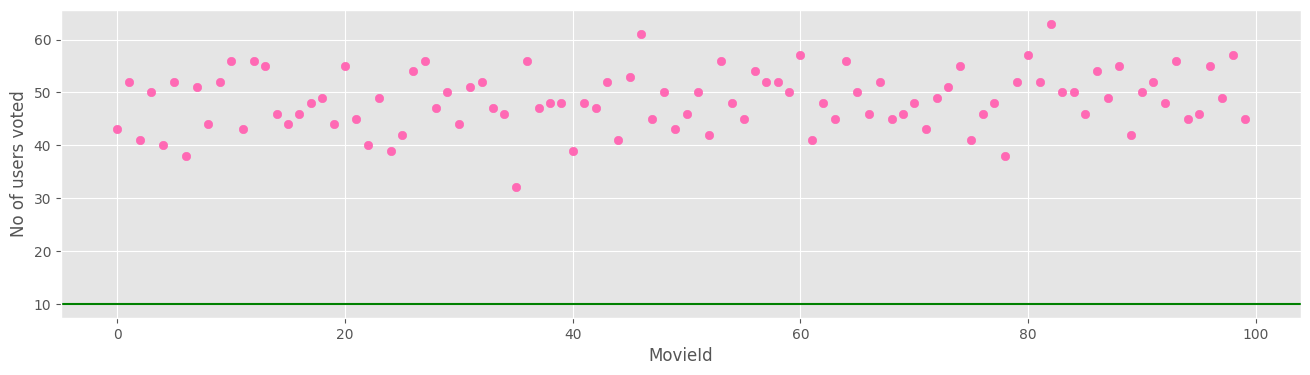

In [16]:
no_user_voted = interaction_df.groupby("tour_id")['rating'].agg('count')
no_movies_voted = interaction_df.groupby("user_id")['rating'].agg('count')

import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig,axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted, color="hotpink")
plt.axhline(y=10, color='green')
plt.xlabel("MovieId")
plt.ylabel("No of users voted")
plt.show()
# print(no_user_voted)


In [17]:
# Check for non-numeric values
if not np.issubdtype(user_item_matrix.values.dtype, np.number):
    print("Non-numeric values detected. Converting to numeric.")
    user_item_matrix = user_item_matrix.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0
user_item_matrix = user_item_matrix.fillna(0)

# Calculate density
dense_matrix = user_item_matrix.values
density = np.count_nonzero(dense_matrix) / (dense_matrix.shape[0] * dense_matrix.shape[1])
print(f"Matrix density: {density:.4f}")

# Decision based on density
if density < 0.1:
    print("Matrix is highly sparse. Using sparse representation.")
    csr_data = csr_matrix(dense_matrix)
else:
    print("Matrix is moderately dense. Using dense representation.")
    csr_data = None  # No sparse matrix conversion


Matrix density: 0.4217
Matrix is moderately dense. Using dense representation.


In [18]:
print(csr_data)

None


In [19]:
# Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split

# Split data into train and test sets first
X_user = interaction_df['user_id'].values
X_tour = interaction_df['tour_id'].values
y = interaction_df['rating'].values

# Split data into train and test sets
X_user_train, X_user_test, X_tour_train, X_tour_test, y_train, y_test = train_test_split(
    X_user, X_tour, y, test_size=0.3, random_state=42, shuffle=True
)

# Normalize the target values (y) after splitting
y_min = y_train.min()
y_max = y_train.max()

y_train_normalized = (y_train - y_min) / (y_max - y_min)
y_test_normalized = (y_test - y_min) / (y_max - y_min)

# Print the normalized values
print(y_train_normalized)
print(y_test_normalized)


[1.   0.5  0.   ... 0.75 1.   0.25]
[0.5  0.25 0.   ... 0.5  0.5  0.75]


In [20]:
binary_y_train = (y_train_normalized >= 0.5).astype(int)
binary_y_test = (y_test_normalized >= 0.5).astype(int)
print(binary_y_train)
print(binary_y_test)

[1 1 0 ... 1 1 0]
[1 0 0 ... 1 1 1]


In [21]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(binary_y_train), y=binary_y_train)
class_weights_dict = dict(enumerate(class_weights))


In [22]:
from keras.layers import LeakyReLU
def build_ncf_model(num_users, num_tours, embedding_dim=32):
    # Inputs
    user_input = Input(shape=(1, ), name="user_input")
    tour_input = Input(shape=(1, ), name="tour_input")

    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name="user_embedding")(user_input)
    tour_embedding = Embedding(input_dim=num_tours, output_dim=embedding_dim, name="tour_embedding")(tour_input)

    # Flatten embeddings
    user_vector = Flatten()(user_embedding)
    tour_vector = Flatten()(tour_embedding)

    # GMF: Element-wise product
    gmf_vector = Multiply()([user_vector, tour_vector])

    # MLP: Concatenate embeddings
    mlp_vector = Concatenate()([user_vector, tour_vector])
    mlp_vector = Dense(32)(mlp_vector)
    mlp_vector = LeakyReLU(alpha=0.01)(mlp_vector)
    mlp_vector = BatchNormalization()(mlp_vector)
    mlp_vector = Dropout(0.4)(mlp_vector)
    mlp_vector = Dense(64)(mlp_vector)
    mlp_vector = LeakyReLU(alpha=0.01)(mlp_vector)
    # mlp_vector = ReLU()(mlp_vector)
    mlp_vector = Dropout(0.2)(mlp_vector)

    # Combine GMF and MLP
    combined_vector = Concatenate()([gmf_vector, mlp_vector])

    # Output layer
    output = Dense(1, activation='sigmoid', name="output")(combined_vector)

    # Build model
    model = Model(inputs=[user_input, tour_input], outputs=output)
    return model


In [23]:
# Model parameters
num_users = len(user_encoder.classes_)
num_tours = len(tour_encoder.classes_)
embedding_dim = 32
optimizer = Adam(learning_rate=1e-3)

In [24]:
# Instantiate the model
ncf_model = build_ncf_model(num_users, num_tours, embedding_dim)
ncf_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# ncf_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae', 'mse'])
ncf_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 tour_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                3680      ['user_input[0][0]']          
                                                                                                  
 tour_embedding (Embedding)  (None, 1, 32)                3200      ['tour_input[0][0]']          
                                                                                             

In [25]:
# Train model
class_weights = {0: 1.0, 1: 1.5}
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
history = ncf_model.fit(
    [X_user_train, X_tour_train], binary_y_train,
    validation_data=([X_user_test, X_tour_test], binary_y_test),
    batch_size=512, epochs=40, verbose=2, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/40


7/7 - 3s - loss: 0.8508 - accuracy: 0.5682 - val_loss: 0.6878 - val_accuracy: 0.5863 - lr: 0.0010 - 3s/epoch - 422ms/step
Epoch 2/40
7/7 - 0s - loss: 0.8133 - accuracy: 0.5965 - val_loss: 0.6852 - val_accuracy: 0.5863 - lr: 0.0010 - 174ms/epoch - 25ms/step
Epoch 3/40
7/7 - 0s - loss: 0.8043 - accuracy: 0.5997 - val_loss: 0.6838 - val_accuracy: 0.5863 - lr: 0.0010 - 107ms/epoch - 15ms/step
Epoch 4/40
7/7 - 0s - loss: 0.7887 - accuracy: 0.6000 - val_loss: 0.6832 - val_accuracy: 0.5863 - lr: 0.0010 - 101ms/epoch - 14ms/step
Epoch 5/40
7/7 - 0s - loss: 0.7777 - accuracy: 0.6027 - val_loss: 0.6831 - val_accuracy: 0.5863 - lr: 0.0010 - 110ms/epoch - 16ms/step
Epoch 6/40
7/7 - 0s - loss: 0.7681 - accuracy: 0.6021 - val_loss: 0.6833 - val_accuracy: 0.5863 - lr: 0.0010 - 108ms/epoch - 15ms/step
Epoch 7/40
7/7 - 0s - loss: 0.7681 - accuracy: 0.6021 - val_loss: 0.6833 - val_accuracy: 0.5863 - lr: 0.0010 - 118ms/epoch - 17ms/step
Epoch 8/40
7/7 - 0s - loss: 0.7657 - accuracy: 0.6018 -

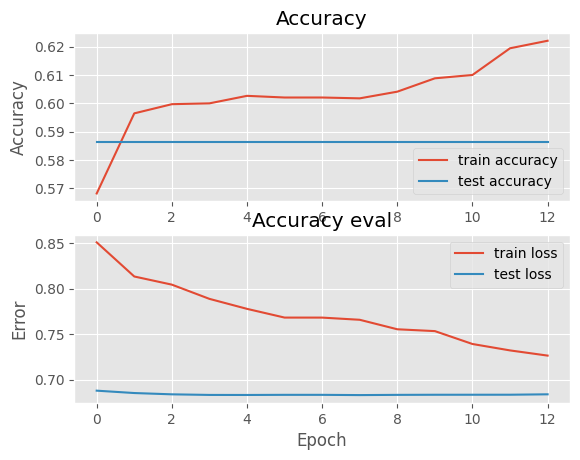

In [26]:
def plot_history(history):
  fig, axs = plt.subplots(2)

  axs[0].plot(history.history['accuracy'], label="train accuracy")
  axs[0].plot(history.history['val_accuracy'], label="test accuracy")
  axs[0].set_ylabel('Accuracy')
  axs[0].legend(loc='lower right')
  axs[0].set_title('Accuracy')

  axs[1].plot(history.history['loss'], label="train loss")
  axs[1].plot(history.history['val_loss'], label="test loss")
  axs[1].set_ylabel('Error')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(loc='upper right')
  axs[1].set_title('Accuracy eval')

  plt.show()


plot_history(history)

In [27]:
test_loss, test_accuracy = ncf_model.evaluate([X_user_test, X_tour_test], binary_y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


46/46 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5863
Test Loss: 0.6830, Test Accuracy: 0.5863


In [28]:
user_id = 5
encoded_user_id = user_encoder.transform([user_id])[0]
all_tours = np.arange(num_tours)

# Predict
user_array = np.full(len(all_tours), encoded_user_id)
predictions = ncf_model.predict([user_array, all_tours])

# Recommend 5 tours
recommended_tours = np.argsort(-predictions.flatten())[:5]
recommended_tour_ids = tour_encoder.inverse_transform(recommended_tours)

print(f"Recommended tours for user {user_id}: {recommended_tour_ids}")


4/4 [==============================] - 0s 3ms/step
Recommended tours for user 5: [16 69 63 48 31]


In [29]:
print(np.bincount(binary_y_train))

[1362 2033]


In [31]:
# Save the model
ncf_model.save('ncf_model.keras')

In [32]:
ncf_model.save("ncf_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(ncf_model, 'tfjs-model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
ncf_model.save("ncf_model_full.h5")


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve --weight_shard_size_bytes=30000000 ./ncf_model.h5 ./ncf_model_js

2024-12-23 02:08:46.423000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734919726.449152    1522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734919726.457060    1522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-package

In [ ]:
ncf_model.save("ncf_model_full.keras")


In [ ]:
import tensorflow as tf
print(tf.__version__)  # TensorFlow version
print(tf.keras.__version__)  # tf.keras version


2.18.0
3.7.0
